In [2]:
from options.test_options import TestOptions
from data.data_loader import CreateDataLoader
from models.models import create_model
import util.util as util
import os
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from tensorboardX import SummaryWriter
import cv2
from PIL import Image
import torch.utils.data as data
from torch.autograd import Variable
import os.path as osp
import torchvision.transforms as transforms
import json
from PIL import ImageDraw
import matplotlib.pyplot as plt

?


In [3]:
class Args:
    name = 'label2city'
    gpu_ids = [0, 1, 2, 3]
    checkpoints_dir = './checkpoints'
    model = 'pix2pixHD'
    norm = 'instance'
    use_dropout = True
    verbose = True
    batchSize = 1
    loadSize = 512
    fineSize = 512
    label_nc = 20
    input_nc = 3
    output_nc = 3
    dataroot = '../../after_vton_difficult_v2/'
    datapairs = 'test_pairs.txt'
    resize_or_crop = 'scale_width'
    serial_batches = True
    no_flip = True
    nThreads = 2
    max_dataset_size = float("inf")
    display_winsize = 512
    tf_log = True
    netG = 'global'
    ngf = 64
    n_downsample_global = 4
    n_blocks_global = 4
    n_blocks_local = 3
    n_local_enhancers = 1
    niter_fix_global = 0
    continue_train = True
    display_freq = 100
    print_freq = 100
    save_latest_freq = 1000
    save_epoch_freq = 10 
    no_html = True
    debug = True
    load_pretrain = '../label2city'
    which_epoch = 'latest'
    phase = 'test'
    niter = 100
    niter_decay = 100
    beta1 = 0.5
    lr = 0.0002
    num_D = 2
    n_layers_D = 3
    ndf = 64
    lambda_feat = 10.0
    no_ganFeat_loss = True
    no_vgg_loss = False
    no_lsgan = True
    pool_size = 0
    isTrain = True

opt = Args

In [4]:
def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir
    f = dir.split('/')[-1].split('_')[-1]
    dirs= os.listdir(dir)
    for img in dirs:
        path = os.path.join(dir, img)
        #print(path)
        images.append(path)
    return images

def get_params(opt, size):
    w, h = size
    new_h = h
    new_w = w
    if opt.resize_or_crop == 'resize_and_crop':
        new_h = new_w = opt.loadSize            
    elif opt.resize_or_crop == 'scale_width_and_crop':
        new_w = opt.loadSize
        new_h = opt.loadSize * h // w

    x = random.randint(0, np.maximum(0, new_w - opt.fineSize))
    y = random.randint(0, np.maximum(0, new_h - opt.fineSize))

def get_transform(method=Image.BICUBIC, normalize=True):
        transform_list = []
        transform_list += [transforms.ToTensor()]
        if normalize:
            transform_list += [transforms.Normalize((0.5, 0.5, 0.5),
                                                    (0.5, 0.5, 0.5))]
        return transforms.Compose(transform_list)
    
class BaseDataset(data.Dataset):
    def __init__(self, opt):
        self.opt = opt
        super(BaseDataset, self).__init__()
        
        human_names = []
        cloth_names = []
        with open(os.path.join(opt.dataroot, opt.datapairs), 'r') as f:
            for line in f.readlines():
                h_name, c_name = line.strip().split()
                human_names.append(h_name)
                cloth_names.append(c_name)
        self.human_names = human_names
        self.cloth_names = cloth_names
        
    def image_for_pose(self, pose_name, transform):
        with open(osp.join(pose_name), 'r') as f:
            pose_label = json.load(f)
            pose_data = pose_label['people'][0]['pose_keypoints']
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1,3))
        point_num = pose_data.shape[0]
        fine_height = 256
        fine_width = 192
        pose_map = torch.zeros(point_num, fine_height, fine_width)
        r = 5
        im_pose = Image.new('L', (fine_width, fine_height))
        pose_draw = ImageDraw.Draw(im_pose)
        for i in range(point_num):
            one_map = Image.new('L', (fine_width, fine_height))
            draw = ImageDraw.Draw(one_map)
            pointx = pose_data[i,0]
            pointy = pose_data[i,1]
            if pointx > 1 and pointy > 1:
                draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
                pose_draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
            one_map = transform(one_map.convert('RGB'))
            pose_map[i] = one_map[0]
        return pose_map
    
    def __getitem__(self, index):        
        c_name = self.cloth_names[index]
        h_name = self.human_names[index]
        A_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_label', h_name.replace(".jpg", ".png"))
        label = Image.open(A_path).convert('L')

        B_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_img', h_name)
        image = Image.open(B_path).convert('RGB') 
        mask = Image.open(B_path).convert('L')
        
        E_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_edge', c_name)
        edge = Image.open(E_path).convert('L')
                
        C_path = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_color', c_name)
        color = Image.open(C_path).convert('RGB')
        
        transform_A = get_transform(method=Image.NEAREST, normalize=False)
        label_tensor = transform_A(label) * 255
        transform_B = get_transform()      
        image_tensor = transform_B(image)
        mask_tensor = transform_A(image)
        edge_tensor = transform_A(edge)
        color_tensor = transform_B(color)
        pose_name = osp.join(self.opt.dataroot, self.opt.phase ,'test' + '_pose', h_name.replace('.jpg', '_keypoints.json'))
        pose_map = self.image_for_pose(pose_name, transform_B)
        
        return {'label': label_tensor, 'image': image_tensor, 
                             'edge': edge_tensor,'color': color_tensor, 
                             'mask': mask_tensor, 'name' : c_name,
                             'colormask': mask_tensor,'pose':pose_map}
    
    def __len__(self):
        return len(self.human_names)

In [5]:
t = BaseDataset(opt)
dataloader = torch.utils.data.DataLoader(
            t,
            batch_size=1,
            shuffle=False)

In [6]:
def changearm(old_label):
    label=old_label
    arm1=torch.FloatTensor((label.cpu().numpy()==11).astype(np.int))
    arm2=torch.FloatTensor((label.cpu().numpy()==13).astype(np.int))
    noise=torch.FloatTensor((label.cpu().numpy()==7).astype(np.int))
    label=label*(1-arm1)+arm1*4
    label=label*(1-arm2)+arm2*4
    label=label*(1-noise)+noise*4
    return label

def gen_noise(shape):
    noise = np.zeros(shape, dtype=np.uint8)
    ### noise
    noise = cv2.randn(noise, 0, 255)
    noise = np.asarray(noise / 255, dtype=np.uint8)
    noise = torch.tensor(noise, dtype=torch.float32)
    return noise.cuda()

def encode_input(label_map, clothes_mask,all_clothes_label):
    size = label_map.size()
    oneHot_size = (size[0], 14, size[2], size[3])
    input_label = torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    input_label = input_label.scatter_(1, label_map.data.long().cuda(), 1.0)

    masked_label= torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    masked_label=masked_label.scatter_(1,(label_map*(1-clothes_mask)).data.long().cuda(), 1.0)

    c_label=torch.cuda.FloatTensor(torch.Size(oneHot_size)).zero_()
    c_label=c_label.scatter_(1,all_clothes_label.data.long().cuda(),1.0)

    input_label = Variable(input_label)

    return input_label,masked_label,c_label

sigmoid = nn.Sigmoid()

for data in dataloader:
    all_clothes_label = changearm(data['label'])
    mask_clothes = torch.FloatTensor((data['label'].cpu().numpy() == 4).astype(np.int))
    mask_fore = torch.FloatTensor((data['label'].cpu().numpy() > 0).astype(np.int))
    img_fore = data['image'] * mask_fore

    in_label = Variable(data['label'].cuda())
    in_edge = Variable(data['edge'].cuda())
    in_img_fore = Variable(img_fore.cuda())
    in_mask_clothes = Variable(mask_clothes.cuda())
    in_color = Variable(data['color'].cuda())
    in_all_clothes_label = Variable(all_clothes_label.cuda())
    in_image = Variable(data['image'].cuda())
    in_pose = Variable(data['pose'].cuda())
    in_mask_fore = Variable(mask_fore.cuda()) 
    pre_clothes_mask = torch.FloatTensor((in_edge.detach().cpu().numpy() > 0.5).astype(np.float)).cuda()
    shape = pre_clothes_mask.shape
    clothes = in_color*pre_clothes_mask
    input_label,masked_label,all_clothes_label = encode_input(in_label,in_mask_clothes,in_all_clothes_label)
    shape = pre_clothes_mask.shape
    break

<ipython-input-6-790ef6cf849b>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  arm1=torch.FloatTensor((label.cpu().numpy()==11).astype(np.int))
<ipython-input-6-790ef6cf849b>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

In [7]:
def image_for_pose(pose_name):
    with open(osp.join(pose_name), 'r') as f:
        pose_label = json.load(f)
        pose_data = pose_label['people'][0]['pose_keypoints']
        pose_data = np.array(pose_data)
        pose_data = pose_data.reshape((-1,3))
    point_num = pose_data.shape[0]
    fine_height = 256
    fine_width = 192
    pose_map = torch.zeros(point_num, fine_height, fine_width)
    r = 5
    im_pose = Image.new('L', (fine_width, fine_height))
    pose_draw = ImageDraw.Draw(im_pose)
    for i in range(point_num):
        pointx = pose_data[i,0]
        pointy = pose_data[i,1]
        if pointx > 1 and pointy > 1:
            pose_draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')
        
    return im_pose

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


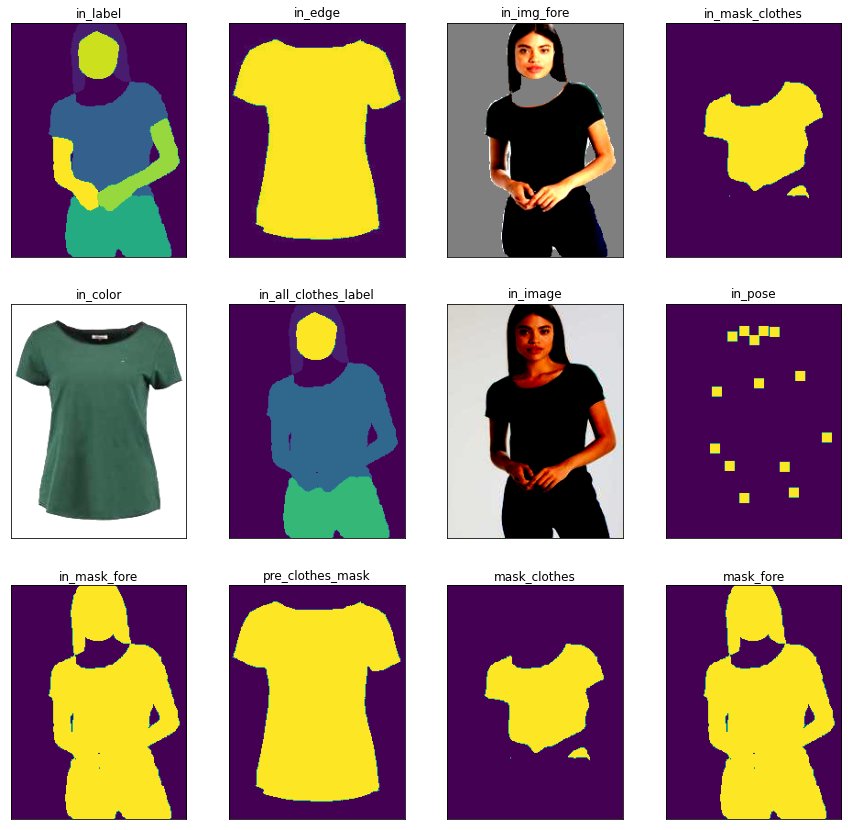

In [8]:
fig = plt.figure(figsize=(15, 25))
rows = 5
col = 4
ax = fig.add_subplot(rows, col, 1)
plt.imshow(in_label[0].permute(1,2,0).detach().cpu().numpy())
plt.title("in_label")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(rows, col, 2)
plt.imshow(in_edge[0].permute(1,2,0).detach().cpu().numpy())
plt.title("in_edge")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(rows, col, 3)
plt.imshow(in_img_fore[0].permute(1,2,0).detach().cpu().numpy()+0.5)
plt.title("in_img_fore")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(rows, col, 4)
plt.imshow(in_mask_clothes[0].permute(1,2,0).detach().cpu().numpy()+0.5)
plt.title("in_mask_clothes")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(rows, col, 5)
plt.imshow(in_color[0].permute(1,2,0).detach().cpu().numpy()+1)
plt.title("in_color")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(rows, col, 6)
plt.imshow(in_all_clothes_label[0].permute(1,2,0).detach().cpu().numpy())
plt.title("in_all_clothes_label")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(rows, col, 7)
plt.imshow(in_image[0].permute(1,2,0).detach().cpu().numpy())
plt.title("in_image")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
in_pose = image_for_pose(osp.join(opt.dataroot, opt.phase, "test_pose", "000012_0_keypoints.json"))
ax = fig.add_subplot(rows, col,8)
plt.imshow(in_pose)
plt.title("in_pose")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(rows, col,9)
plt.imshow(in_mask_fore[0].permute(1,2,0).detach().cpu().numpy())
plt.title("in_mask_fore")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(rows, col,10)
plt.imshow(pre_clothes_mask[0].permute(1,2,0).detach().cpu().numpy())
plt.title("pre_clothes_mask")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(rows, col,11)
plt.imshow(mask_clothes[0].permute(1,2,0).detach().cpu().numpy())
plt.title("mask_clothes")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax = fig.add_subplot(rows, col,12)
plt.imshow(mask_fore[0].permute(1,2,0).detach().cpu().numpy())
plt.title("mask_fore")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

<ipython-input-9-c3371057efcc>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a = torch.FloatTensor((label==0).astype(np.int))
<ipython-input-9-c3371057efcc>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy

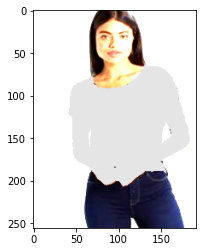

In [9]:
def changearm(label):
    label = label.cpu().numpy()
    a = torch.FloatTensor((label==0).astype(np.int))
    b = torch.FloatTensor((label==1).astype(np.int))
    c = torch.FloatTensor((label==8).astype(np.int))
    d = torch.FloatTensor((label==12).astype(np.int))
    return a+b+c+d

clothes_and_arm = changearm(data['label'])
no_middle = data['image'] * clothes_and_arm
plt.imshow(no_middle[0].permute(1,2,0).detach().cpu().numpy() + 0.9)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


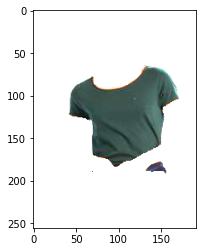

In [12]:
t = in_image.detach().cpu()*mask_clothes.detach().cpu()
plt.imshow(t[0].permute(1,2,0).numpy()+1)
